## SVM with SMO.

In this notebook I'm planning to build the SVM model using the SMO algorithm. I'll break down the process to the following steps:
* SVM using SMO for the linearly seperable case.
* SVM using SMO for the non seperable case.
* Integrating Kernels into the model. 
* Benchmark the final model against the vanilla SVM in CS231 on the CIFAR dataset.

For each bullet point I'll create some visualization to help us better understand what the model is doing. To begin with the linearly seperable case I will look at the Iris dataset and I'm going to make sure that the data is in fact linearly seperable. 

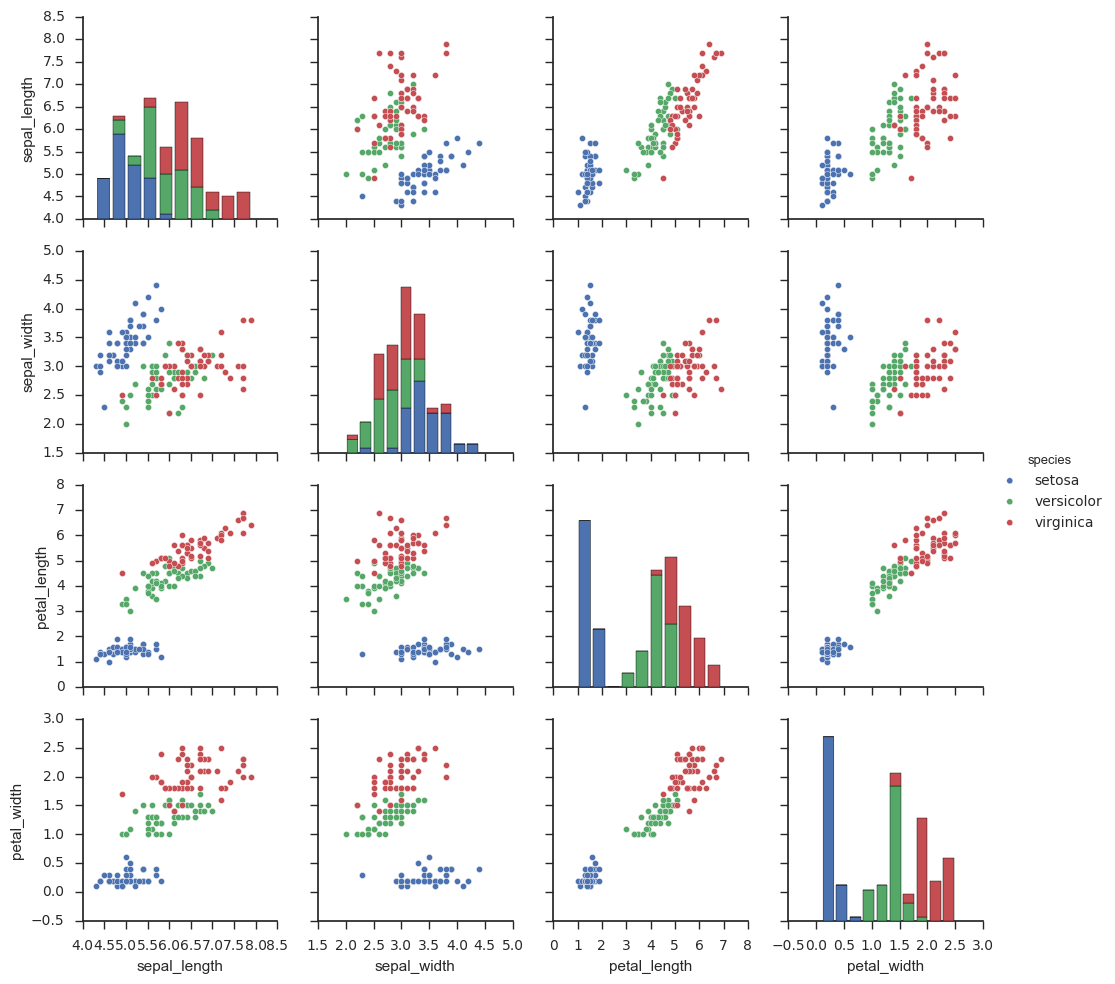

In [32]:
# Let's draw a matrix scatter plot for the Iris dataset 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

iris=sns.load_dataset('iris')
sns.pairplot(iris, hue='species')
plt.show()

Unfortunately it seems that the data is not linearly seperable. However, if we zoom into the plot with ("petal_length", "petal_width") we see that combining "versicolor" and "viginica" can give us what we are looking for.

In [27]:
# I now select "petal_length" and "petal_width" as my variables for the data.
iris_lin_sep = iris[['petal_length','petal_width', 'species']].copy()

# I will combine "versicolor" and "virginica" into one class.
iris_lin_sep.loc[iris_lin_sep['species']=='setosa', 'species'] = 1
iris_lin_sep.loc[iris_lin_sep['species']=='virginica', 'species'] = -1
iris_lin_sep.loc[iris_lin_sep['species']=='versicolor', 'species'] = -1


Now that the data is ready we can start applying the SVM algorithm to it.